In [2]:
import sys
mainpath='c:/Kitti/Dropbox/PHD/Gridshells-EQCS' #location of folders
sys.path.insert(0, mainpath+'/Tekno') #location of python files

In [3]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import Tekno as tk
import Types as tp
import numpy as np
import Imperfection as imp
import Plot as ptk
from plotly.offline import iplot as iplt
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
from plotly.graph_objs import Layout, Data, Figure, Marker, Scatter
from scipy.interpolate import UnivariateSpline
from plotly import tools
import pickle
import pandas as pd
from scipy import optimize
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 14
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

In [4]:
import importlib #for reloading
importlib.reload(tk)
import Tekno as tk

# Parameters

materially and geometrically nonlinear finite element analysis to determine the ultimate load of grid shells

grid shells with various span (L), spen-to-height ratio (L/H), grid density (gN) and pipe cross-section sizes (D, T)

to see results either load previously calculated and saved results or run analyses

In [5]:
runNb=30
LperHA = np.zeros(runNb, dtype=np.int16)
gNA    = np.zeros(runNb, dtype=np.int16)
SpanA  = np.zeros(runNb, dtype=np.int16)
DStart = np.zeros(runNb)
DStep  = np.zeros(runNb)
tStart = np.zeros(runNb, dtype=np.int16)
tStep  = np.zeros(runNb, dtype=np.int16)
FA     = np.zeros(runNb)
Data   = np.zeros((runNb,8), dtype=np.int16)

Data[0]  = 10, 20, 60, 200, 100, 20, 5,  -500
Data[1]  = 8,  16, 20, 80,  50,  5,  5,  -500
Data[2]  = 6,  16, 40, 200, 50,  10, 10, -900
Data[3]  = 5,  20, 40, 100, 50,  10, 10, -500
Data[4]  = 4,  16, 20, 50,  25,  5,  10, -500
Data[5]  = 3,  24, 60, 120, 60,  10, 10, -500

Data[6]  = 10, 16, 30, 120, 60,  10, 10, -500
Data[7]  = 8,  16, 40, 120, 60,  10, 10, -500
Data[8]  = 6,  20, 50, 180, 60,  10, 10, -500
Data[9]  = 5,  24, 50, 120, 60,  10, 10, -150
Data[10] = 4,  20, 40, 100, 50,  10, 10, -500
Data[11] = 3,  18, 30, 100, 50,  5,  10, -500

Data[12] = 10, 10, 20, 50,  50,  5,  10, -500
Data[13] = 8,  16, 60, 150, 100, 15, 10, -500
Data[14] = 6,  28, 60, 150, 75,  10, 10, -500
Data[15] = 5,  24, 20, 50,  25,  5,  10, -500
Data[16] = 4,  16, 50, 120, 60,  10, 10, -500
Data[17] = 3,  8,  40, 100, 50,  5, 10,  -500

Data[18] = 10, 12, 60, 200, 100, 15, 10, -1100
Data[19] = 8,  10, 60, 250, 100, 15, 10, -1100
Data[20] = 6,  28, 30, 100, 50,  5,  10, -100
Data[21] = 5,  24, 40, 150, 50,  5,  10, -500
Data[22] = 4,  24, 20, 50,  20,  5,  10, -35 # new convergence criteria and more load steps
Data[23] = 3,  12, 20, 50,  35,  5,  10, -500

Data[24] = 10, 22, 60, 150, 150, 10, 10, -500
Data[25] = 8,  20, 60, 150, 150, 15, 10, -700
Data[26] = 6,  14, 30, 100, 50,  10, 10, -500
Data[27] = 5,  16, 40, 120, 60,  10, 10, -500
Data[28] = 4,  12, 20, 60,  30,  5,  10, -500
Data[29] = 3,  16, 20, 50,  25,  5,  10, -80 # new convergence criteria and more load steps

for i in range(runNb):
    LperHA[i],gNA[i],SpanA[i],DStart[i],DStep[i],tStart[i],tStep[i],FA[i] = Data[i,0],Data[i,1],Data[i,2],Data[i,3],Data[i,4],Data[i,5],Data[i,6],Data[i,7]

In [6]:
MatNL = True
n=4 # mm CHS cross-section diameter
m=1 # mm CHS cross-section thickness
nb = 4   # number of finite elements along one beam

In [7]:
size = 50
GRSA       = np.zeros(size, dtype=tp.GridShell)
CapacityFA = np.zeros((size, n*m))
CapacityA  = np.zeros((size, n*m))
rhoAA      = np.zeros((size, n*m))
IDA        = np.zeros(size, dtype=np.int16)
etaA       = np.zeros((size, n*m)) 
loadAA     = np.zeros((size, n*m, 51))
dispA      = np.zeros((size, n*m, 51))

     L  g  LpH   Lav  L/Lav
----------------------------
 0: 60  20  10   4.7  12.7  2221
 1: 20  16   8   2.0  10.2  1457
 2: 40  16   6   4.0  10.0  1457
 3: 40  20   5   3.3  12.3  2221
 4: 20  16   4   2.1   9.6  1457
 5: 60  24   3   4.4  13.6  3145

 6: 30  16  10   2.9  10.2  1457
 7: 40  16   8   3.9  10.2  1457
 8: 50  20   6   4.0  12.4  2221
 9: 50  24   5   3.4  14.6  3145
10: 40  20   4   3.3  11.9  2221
11: 30  18   3   2.9  10.3  1819

12: 20  10  10   3.1   6.6  611
13: 60  16   8   5.9  10.2  1457
14: 60  28   6   3.5  17.2  4229
15: 20  24   5   1.4  14.6  3145
16: 50  16   4   5.2   9.6  1457
17: 40   8   3   8.3   4.8  409

18: 60  12  10   7.7   7.8  853
19: 60  10   8   9.2   6.5  611
20: 30  28   6   1.7  17.2  4229
21: 40  24   5   2.7  14.6  3145
22: 20  24   4   1.4  14.2  3145
23: 20  12   3   2.9   7.0  853

24: 60  22  10   4.3  13.9  2663
25: 60  20   8   4.8  12.6  2221
26: 30  14   6   3.4   8.8  1135
27: 40  16   5   4.0   9.9  1457
28: 20  12   4   2.7

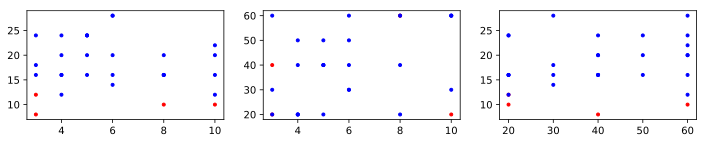

In [6]:
print('     L  g  LpH   Lav  L/Lav')
print('----------------------------')
for i in range(runNb):
    lavtemp, ndnb = tk.calclav2(SpanA[i],LperHA[i],gNA[i])
    print('{:2d}: {:.0f}  {:2.0f}  {:2.0f}  {:4.1f}  {:4.1f}  {:2d}'.format(i,SpanA[i],gNA[i],LperHA[i],lavtemp,SpanA[i]/lavtemp, ndnb))
    if i%6==5: print()
plt.figure(figsize=(12,2))
plt.subplot(131)
for i in range(runNb): 
    if SpanA[i]/tk.calclav(SpanA[i],LperHA[i],gNA[i])>7.05: plt.plot(LperHA[i],gNA[i],'bo', ms=3) # 
    else: plt.plot(LperHA[i],gNA[i],'ro', ms=3) # 
plt.subplot(132)
for i in range(runNb): 
    if SpanA[i]/tk.calclav(SpanA[i],LperHA[i],gNA[i])>7.05: plt.plot(LperHA[i],SpanA[i],'bo', ms=3) # 
    else: plt.plot(LperHA[i],SpanA[i],'ro', ms=3) # 
plt.subplot(133)
for i in range(runNb): 
    if SpanA[i]/tk.calclav(SpanA[i],LperHA[i],gNA[i])>7.05: plt.plot(SpanA[i],gNA[i],'bo', ms=3) # 
    else: plt.plot(SpanA[i],gNA[i],'ro', ms=3) # 
plt.show()

# Load

In [8]:
ga = pickle.load( open( mainpath+"/Saved results/GRSA_OldalnyomasosALL_Geom1_i300.p", "rb" ) )
with pd.HDFStore(mainpath+'/Saved results/OldalnyomasosALL_Geom1_i300.h5') as store:
    ca = store['CapacityA']
    cf = store['CapacityFA']
    rh = store['rhoAA']
    et = store['etaA']
    l1 = store['loadA1']
    l2 = store['loadA2']
    l3 = store['loadA3']
    l4 = store['loadA4']
    d1 = store['dispA1']
    d2 = store['dispA2']
    d3 = store['dispA3']
    d4 = store['dispA4']

In [9]:
size = 50
GRSA = ga
CapacityA  = ca.values
CapacityFA = cf.values
rhoAA      = rh.values
etaA       = et.values
loadAA     = np.zeros((size, n*m, 51))
loadAA[:,0,:]  = l1.values
loadAA[:,1,:]  = l2.values
loadAA[:,2,:]  = l3.values
loadAA[:,3,:]  = l4.values
dispA      = np.zeros((size, n*m, 51))
dispA[:,0,:]   = d1.values
dispA[:,1,:]   = d2.values
dispA[:,2,:]   = d3.values
dispA[:,3,:]   = d4.values

# Analysis

In [35]:
for i in {29}:
    amp=SpanA[i]/300
    GRSA[i], CapacityFA[i], CapacityA[i], rhoAA[i], etaA[i], loadAAlarge, dispAlarge= tk.loop_analyse_imp(n, m, LperHA[i], gNA[i], SpanA[i], nb, FA[i], DStart[i], DStep[i], tStart[i], tStep[i],amp,steps=200,msz=0.01)
    
    for j in range(51):
        loadAA[i,:,j]=loadAAlarge[:,j*4]
        dispA[i,:,j]=dispAlarge[:,j*4]    

25.03
75.57
155.12
272.11


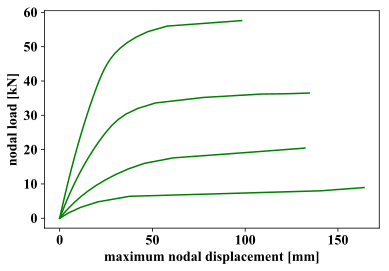

In [10]:
j=29
for i in range(n*m):
    plot = plt.plot(dispA[j,i],loadAA[j,i],'g') # dot plot
plot = plt.xlabel('maximum nodal displacement [mm]')
plot = plt.ylabel('nodal load [kN]')

## Reference

In [11]:
c1=[c/255. for c in [213., 94., 0.]] # vermillion
c2=[c/255. for c in [0, 158, 115]] # bluish green
c3=[c/255. for c in [240, 228, 66]]  # yellow
c4=[c/255. for c in [0, 114, 178]]   # blue
c5=[c/255. for c in [204, 121, 167]] # reddish purple
c6=[c/255. for c in [86, 180, 233]] # sky blue
#c1=[c/255. for c in [230, 159, 0]]   # orange
col=[c1,c2,c3,c4,c5,c6]
mar = ['o', '<', 'D', 'v', 'X', '>','s']
c=np.zeros(6)
LperHAord=np.array([LperHA[0],LperHA[1], LperHA[2], LperHA[3], LperHA[4], LperHA[5]])
for i in range(6):
    c[i]=(LperHAord[i]-12)**2/51+0.92
Cmax=20
Cmin=3

[ 0.36137633]


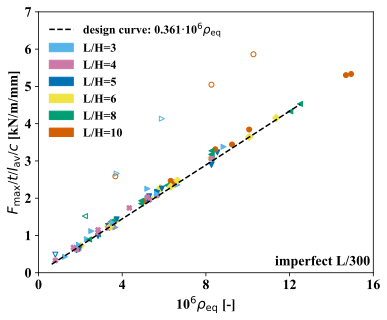

In [12]:
plt.figure(figsize=(6,4.8))

#load perfect results
CapacityAp  = np.zeros((size, n*m))
rhoAAp      = np.zeros((size, n*m))
ga = pickle.load( open(mainpath+ "/Saved results/GRSA_OldalnyomasosALL_Geom1.p", "rb" ) )
with pd.HDFStore(mainpath+'/Saved results/OldalnyomasosALL_Geom1.h5') as store:
    ca = store['CapacityA']
    rh = store['rhoAA']
CapacityAp  = ca.values[30:60]
rhoAAp      = rh.values[30:60]

refx=np.zeros(runNb*4+1)
refy=np.zeros(runNb*4+1)
k=0
for i in range(runNb):
    if GRSA[i]!=0:
        if GRSA[i].span/GRSA[i].Lav>0:
            perf=np.interp(rhoAA[i], rhoAAp[i], CapacityAp[i])
            decrese=(perf-CapacityA[i])/perf
            for j in range(n*m):
                if CapacityA[i,j]>=Cmin and CapacityA[i,j]<=Cmax and rhoAA[i,j]*1e6<=15:
                    if decrese[j]>0.15:
                        if GRSA[i].span/GRSA[i].Lav>8:
                            k+=1
                            refx[k]=rhoAA[i,j]
                            refy[k]=CapacityFA[i,j] /GRSA[i].secT/1000 / GRSA[i].Lav /c[(i)%6]   
                        plt.plot(rhoAA[i,j] *1e6, CapacityFA[i,j] /GRSA[i].secT/1000 / GRSA[i].Lav /c[(i)%6], color=col[i%6], marker=mar[i%6], ms=5)
                    else:
                        plt.plot(rhoAA[i,j] *1e6, CapacityFA[i,j] /GRSA[i].secT/1000 / GRSA[i].Lav /c[(i)%6], color=col[i%6], marker=mar[i%6], ms=5, fillStyle='none')
                    
keys=np.argsort(refx)
refx=refx[keys]
refy=refy[keys]

def linf(x, a1):
    return a1 * x

params, _ = optimize.curve_fit(linf, refx* 1e6, refy)
params[0]=0.97*params[0] #so that minimal error is above -10%
refxlin=np.linspace(0,12.5,100)
plt.plot(refxlin[5:],linf(refxlin[5:],params[0]),'k--')
print(params)

plt.xlabel('10$^6\\rho_{\\rm eq}$ [-]')
plt.ylabel('$F_{\\rm max}$/$t$/$l_{\\rm av}$/$c$ [kN/m/mm]')
plt.xlim(0,16)
plt.ylim(0,7)
plt.xticks(np.arange(0,16.1,4))
plt.text(11.3, 0.2, 'imperfect L/300')

ref_ln = mlines.Line2D([], [], color='k', label='design curve: 0.361$\cdot$10$^6 \\rho_{\\rm eq}$',linestyle='--')
c_patch = mpatches.Patch(color=c6, label='L/H=3')
m_patch = mpatches.Patch(color=c5, label='L/H=4')
b_patch = mpatches.Patch(color=c4, label='L/H=5')
y_patch = mpatches.Patch(color=c3, label='L/H=6')
g_patch = mpatches.Patch(color=c2, label='L/H=8')
r_patch = mpatches.Patch(color=c1, label='L/H=10')
plt.legend(handles=[ref_ln,c_patch,m_patch,b_patch,y_patch,g_patch,r_patch],frameon=False,loc=2,fontsize=12)

plt.savefig('G1_300.pdf', bbox_inches='tight')

plt.show()

# Hiba

In [13]:
iplt(tk.calc_error(GRSA,rhoAA,CapacityA,refxlin*1e-6,linf(refxlin,params[0]),detailOn=False, runNb=30, runNbfrom=0))

Max error:        49.3%
Min error:        -10.7%
Average error:     8.6%
84


# Save results

In [48]:
pickle.dump(GRSA, open( mainpath+"/Saved results/GRSA_OldalnyomasosALL_Geom1_i300.p", "wb" ) )

In [49]:
A_df  = pd.DataFrame(CapacityA, columns=('sec1', 'sec2', 'sec3', 'sec4'))
B_df  = pd.DataFrame(CapacityFA, columns=('sec1', 'sec2', 'sec3', 'sec4'))
C_df  = pd.DataFrame(rhoAA, columns=('sec1', 'sec2', 'sec3', 'sec4'))
D_df  = pd.DataFrame(etaA, columns=('sec1', 'sec2', 'sec3', 'sec4'))
E_df1 = pd.DataFrame(loadAA[:,0,:]) #sec1
E_df2 = pd.DataFrame(loadAA[:,1,:]) #sec2
E_df3 = pd.DataFrame(loadAA[:,2,:]) #sec3
E_df4 = pd.DataFrame(loadAA[:,3,:]) #sec4
F_df1 = pd.DataFrame(dispA[:,0,:])  #sec1
F_df2 = pd.DataFrame(dispA[:,1,:])  #sec2
F_df3 = pd.DataFrame(dispA[:,2,:])  #sec3
F_df4 = pd.DataFrame(dispA[:,3,:])  #sec4
G_df  = pd.DataFrame(refxlin)
H_df  = pd.DataFrame(linf(refxlin,params[0]))

with pd.HDFStore(mainpath+'/Saved results/OldalnyomasosALL_Geom1_i300.h5') as store:
    store['CapacityA'] = A_df
    store['CapacityFA']= B_df
    store['rhoAA']     = C_df
    store['etaA']      = D_df
    store['loadA1']    = E_df1
    store['loadA2']    = E_df2
    store['loadA3']    = E_df3
    store['loadA4']    = E_df4
    store['dispA1']    = F_df1
    store['dispA2']    = F_df2
    store['dispA3']    = F_df3
    store['dispA4']    = F_df4
    store['refx']      = G_df
    store['refy']      = H_df